# DensePose COCO数据集和SMPL模型

本文档演示了SMPL模型上关键点的定位。


### 下载SMPL模型（代码中已含）
* 打开网页 https://smpl.is.tue.mpg.de/ 并注册。

* 点击网站顶部导航栏的 **Downloads**，下载 **SMPL for Python Users** - **Download**中的 **version 1.0.0** 与**UV map**两个文件，并解压缩。

* 复制解压缩后的男性模板文件
<span style=“color:#900C3F”> **'models/basicModel_f_lbs_10_207_0_v1.0.0.pkl'** </span>到 **DensePoseData/** 文件夹。

现在我们可以可视化SMPL模板模型。

In [1]:
# python的经典2D绘图库
import matplotlib.pyplot as plt
# matplotlib下的子模块，用于绘制3D模型
from mpl_toolkits.mplot3d import axes3d, Axes3D 
# python的经典数据处理库
import numpy as np
# Python的数据序列化/反序列化模块
import pickle
import os

# 如果路径不对，将DensePoseData_dir改为你的绝对路径
# DensePoseData_dir = "D:\\projects\\DensePose\\DensePoseData"
DensePoseData_dir = os.path.abspath("../DensePoseData")
print(DensePoseData_dir)

# 原模型为python 2.7版本，不能直接用python 3.x版本的pickle读取，需要进行encoding处理
def load_pickle_py27(file_path):
    with open(file_path, 'rb') as f:
        u = pickle._Unpickler(f) # 调用pickle
        u.encoding = 'latin1'
        data = u.load()
    return data

# 读取SMPL基础模型，共6090个顶点，坐标格式为(x, y, z)
data = load_pickle_py27(os.path.join(DensePoseData_dir, 'basicmodel_m_lbs_10_207_0_v1.0.0.pkl'))
Vertices = data['v_template']  ##  Loaded vertices of size (6890, 3)
print(Vertices.shape)
X,Y,Z = [Vertices[:,0], Vertices[:,1],Vertices[:,2]]

d:\projects\CG_E4_data\DensePose\DensePoseData
(6890, 3)


让我们定义一些函数，将SMPL模型顶点可视化为点云，显示整个身体并放大到面部：

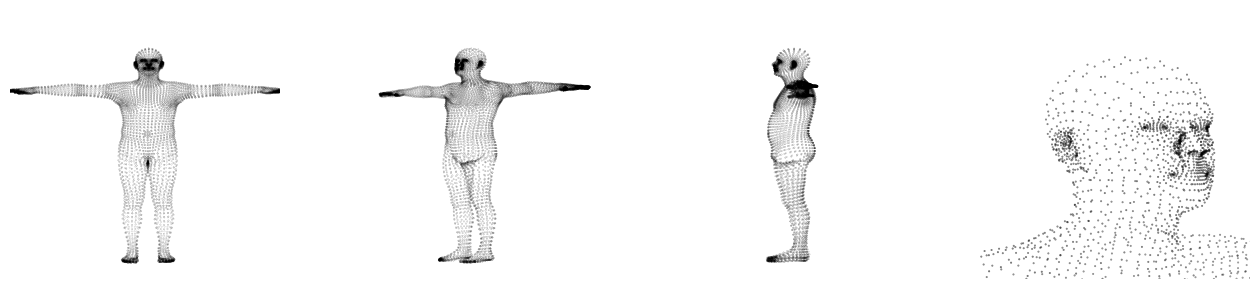

In [2]:
# 具体参数通过手动校准得到
def smpl_view_set_axis_full_body(ax,azimuth=0):
    ## Manually set axis 
    ax.view_init(0, azimuth)
    max_range = 0.55
    ax.set_xlim( - max_range,   max_range)
    ax.set_ylim( - max_range,   max_range)
    ax.set_zlim( -0.2 - max_range,   -0.2 + max_range)
    ax.axis('off')
    
def smpl_view_set_axis_face(ax, azimuth=0):
    ## Manually set axis 
    ax.view_init(0, azimuth)
    max_range = 0.1
    ax.set_xlim( - max_range,   max_range)
    ax.set_ylim( - max_range,   max_range)
    ax.set_zlim( 0.45 - max_range,   0.45 + max_range)
    ax.axis('off')

## Now let's rotate around the model and zoom into the face.
# 可视化T-Pose的完整SMPL模型，只显示顶点

fig = plt.figure(figsize=[16,4])

# 身体旋转0/45/90度
ax = fig.add_subplot(141, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax)

ax = fig.add_subplot(142, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax,45)

ax = fig.add_subplot(143, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax,90)

# 面部旋转-40度
ax = fig.add_subplot(144, projection='3d')
ax.scatter(Z,X,Y,s=0.2,c='k')
smpl_view_set_axis_face(ax,-40)

plt.show()

为了简单起见，我们有一个单独的密集注释 **“demo_dp_single_ann.pkl”** 用于演示。

下面，我们加载神经网络并找到相应的人脸索引和重心坐标，这使我们能够在3D表面上定位该点。

In [3]:
import detectron.utils.densepose_methods as dp_utils

# 将linux下的plk文件转为windows下的格式，区别在于"\n"与"\n\r"
def fix_plk_format(ori_path, dst_path):
    content = ''
    outsize = 0
    with open(ori_path, 'rb') as infile:
        content = infile.read()
    with open(dst_path, 'wb') as output:
        for line in content.splitlines():
            outsize += len(line) + 1
            output.write(line + str.encode('\n'))

# original：原始linux下的pkl文件，destination：修改后的windows可读pkl文件
original =  os.path.join(DensePoseData_dir, "demo_data/demo_dp_single_ann.pkl")
destination = os.path.join(DensePoseData_dir, "demo_data/demo_dp_single_ann_win.pkl")
fix_plk_format(original, destination)

# 读取标注信息，x、y、i、u、v含义可参考COCO-Visualize.ipynb中的介绍
DP = dp_utils.DensePoseMethods(DensePoseData_dir)
Demo = load_pickle_py27(destination)

# 注意此处为三维，表示SMPL模型中的关键点；此处的Demo['x']仅用来表示关键点个数
# 需要把此处通过IUV转换的三维collected_x、collected_y与二维的Demo['x']、Demo['y']辨别
collected_x = np.zeros(Demo['x'].shape)
collected_y = np.zeros(Demo['x'].shape)
collected_z = np.zeros(Demo['x'].shape)

# 与SMPL对应的贴图
for i, (ii,uu,vv) in enumerate(zip(Demo['I'],Demo['U'],Demo['V'])):
    # Convert IUV to FBC (faceIndex and barycentric coordinates.)
    FaceIndex,bc1,bc2,bc3 = DP.IUV2FBC(ii,uu,vv)
    # Use FBC to get 3D coordinates on the surface.
    p = DP.FBC2PointOnSurface( FaceIndex, bc1,bc2,bc3,Vertices )
    # 3D关键点坐标
    collected_x[i] = p[0]
    collected_y[i] = p[1]
    collected_z[i] = p[2]

让我们在SMPL模型上可视化收集到的点：

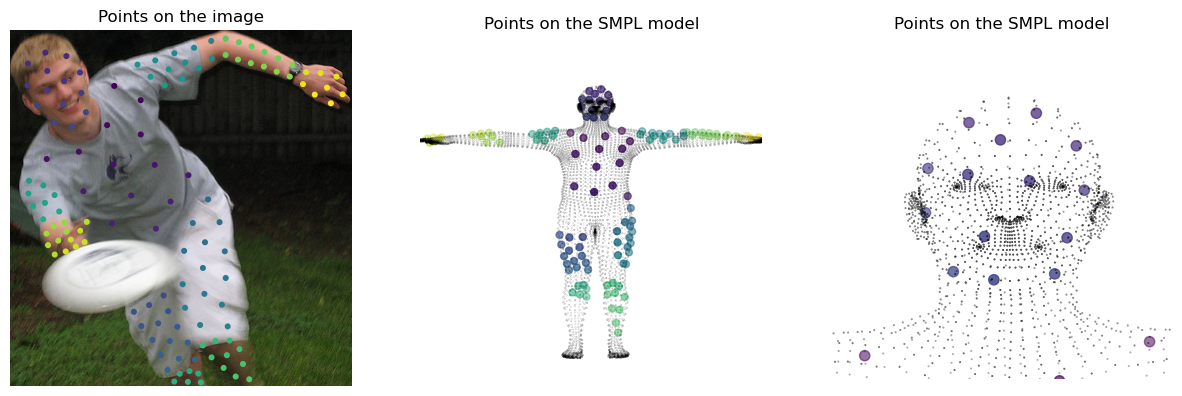

In [4]:
fig = plt.figure(figsize=[15,5])

# 原图像中标注的2D身体关键点，仅x、y坐标
# Visualize the image and collected points.
ax = fig.add_subplot(131)
ax.imshow(Demo['ICrop']) # 原始RGB图像
ax.scatter(Demo['x'],Demo['y'],11, np.arange(len(Demo['y'])) ) # 在图像中加入散点
plt.title('Points on the image')
ax.axis('off'), 

# 与标注对应的标准SMPL模型（T-Pose）中的3D身体关键点
## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(132, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
ax.scatter(collected_z,  collected_x,collected_y,s=25,  c=  np.arange(len(Demo['y']))    )
smpl_view_set_axis_full_body(ax)
plt.title('Points on the SMPL model')

# 对应的T-Pose标准SMPL模型中的面部关键点
## Now zoom into the face.
ax = fig.add_subplot(133, projection='3d')
ax.scatter(Z,X,Y,s=0.2,c='k')
ax.scatter(collected_z,  collected_x,collected_y,s=55,c=np.arange(len(Demo['y'])))
smpl_view_set_axis_face(ax)
plt.title('Points on the SMPL model')
#
plt.show()